# Avaliação das previsões geradas pelo modelo ARIMA 

Neste trabalho é avaliada a performance do modelo ARIMA para a previsão da média de casos de 7 dias utilizando dados fora do período de treino do modelo. No trabalho anterior foram testadas modelos AR e MA, mas, como o ARIMa teve desempenho melhor na maioria dos países ele foi o selecionado para prosseguir nesta fase do projeto.

ARIMA(2, 2, 7)

## Bibliotecas necessárias

In [56]:
from funcoes_arima import read_data
from funcoes_arima import arima_model_plot
from funcoes_arima import sarima_model_plot
from funcoes_arima import autoArima
from funcoes_arima import plot_diffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
from pmdarima.arima import auto_arima
import pandas as pd

Função para gerar previsões com o modelo ARIMA

In [57]:
def arima_model(train_data, test_data, p=0, d=0, q=0, P=0, D=0, Q=0, m=0, country='', model_name='',
                horizon=1, y_lim=6_000, country_plot=''):
    model = ARIMA(train_data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
    model = model.fit()
    fcst = []
    data = train_data.copy()

    for i in range(len(test_data)):
        fcst.append([data.index[-1], *model.forecast(horizon).values[:]])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
        #model = model_test.fit()
        model = model_test.smooth(model.params)

    fcst = pd.DataFrame(fcst)
    fcst.columns = ['fcst_date', *[f'h{i}' for i in range(1, horizon+1)]]
    fcst.set_index('fcst_date', inplace=True)
    fcst[f'{horizon}day_average'] = fcst.mean(axis=1)
    
    data_fcst = data.loc[fcst.index].rolling(horizon).mean().shift(-horizon).dropna()
    train_avg = data['New_Confirmed'].rolling(horizon).mean()
    fig, ax = plt.subplots(1)
    fcst = fcst.loc[data_fcst.index]
    fcst[f'{horizon}day_average_observed'] = data_fcst
    
    fcst.loc[data_fcst.index][f'{horizon}day_average'].plot(ax=ax, label='Previsão')
    train_avg.plot(ax=ax, label='Série observada')
    
    plt.legend()
    plt.title(f'Média móvel de 7 dias: Previsto x Observado {country_plot}')
    plt.ylim(0, y_lim)
    plt.xlim('2020-03-01', fcst.index[-1])
    
    # ax.set_xticks([], minor=True)
    labels = [datetime.strftime(x, '%d-%m') for x in fcst.index[::5]]
    # ax.set_xticks(ticks=train_avg.index[::5], labels=labels)
    ax.set_ylabel('Número de casos')
    ax.set_xlabel('')
    return fcst

In [58]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from datetime import timedelta

def avalia_previsoes(fcst, test):

    results = []

    for i in range(1, 8):
        fcst_h = fcst[[f'h{i}']]
        fcst_h.index += timedelta(days=i)
        obs = test.loc[fcst_h.index]
        results.append([
            f'h{i}',
            r2_score(obs, fcst_h),
            np.sqrt(mean_squared_error(obs, fcst_h)),
            mean_absolute_error(obs, fcst_h),
            mean_absolute_percentage_error(obs, fcst_h),
            np.corrcoef(obs.values[:, 0], fcst_h.values[:, 0])[0, 1]
        ])

    results.append([
            f'7 dias',
            r2_score(fcst['7day_average_observed'], fcst['7day_average']),
            np.sqrt(mean_squared_error(fcst['7day_average_observed'], fcst['7day_average'])),
            mean_absolute_error(fcst['7day_average_observed'], fcst['7day_average']),
            mean_absolute_percentage_error(fcst['7day_average_observed'], fcst['7day_average']),
            np.corrcoef(fcst['7day_average_observed'],  fcst['7day_average'])[0, 1]
        ])
    results = pd.DataFrame(results, columns=['horizonte', 'r²', 'RMSE', 'MAE', 'MAPE', 'Correl'])
    print(results)
    return results

### México

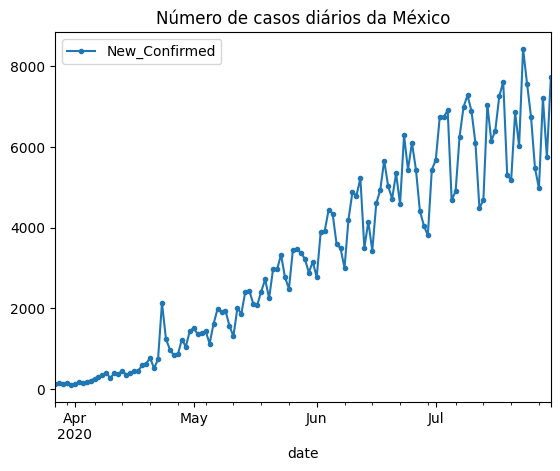

In [59]:
reg_data_mx = read_data('MX')
reg_data_mx = reg_data_mx.loc[reg_data_mx.ge(100).idxmax()[0]:]
reg_data_mx.plot(marker='.')
plt.title('Número de casos diários da México');

In [60]:
train_data = reg_data_mx.iloc[:88]
test_data = reg_data_mx.iloc[88:]

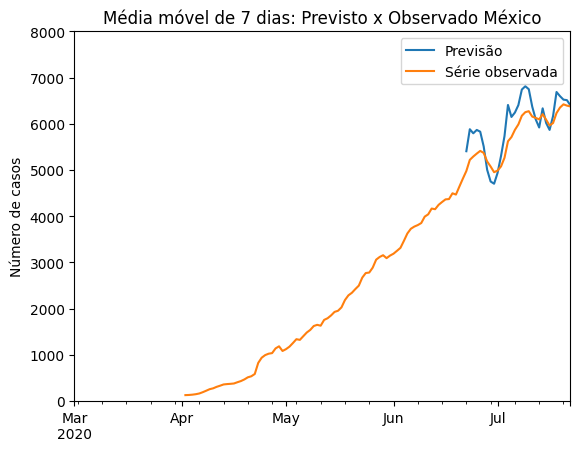

In [61]:
fcst_mx = arima_model(train_data, test_data, p=1, d=1, q=1, P=1, D=0, Q=0, m=7,
                      model_name='SARIMA', country='México', horizon=7,
                      y_lim=8_000, country_plot='México')

In [62]:
metricas_mx = avalia_previsoes(fcst_mx, test_data)
# metricas_mx.to_csv('../../avaliavao_mexico.csv', index=False)

  horizonte        r²         RMSE         MAE      MAPE    Correl
0        h1  0.399268   858.313312  701.711820  0.119417  0.636729
1        h2  0.288806   962.593487  771.119251  0.132872  0.544463
2        h3  0.223205  1007.467552  784.245911  0.135987  0.504155
3        h4  0.222753  1011.920854  795.858883  0.139460  0.512190
4        h5  0.229350  1017.223217  820.218845  0.144093  0.525062
5        h6  0.217175  1006.340851  832.670578  0.143505  0.532247
6        h7  0.190735   967.296366  794.796413  0.131252  0.532402
7    7 dias -0.467170   621.471575  495.548774  0.084379  0.375565


In [63]:
p=1
d=1
q=1
P=1
D=0
Q=0
m=7
model = ARIMA(train_data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model = model.fit()
forecast = model.get_forecast(17)


In [64]:
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

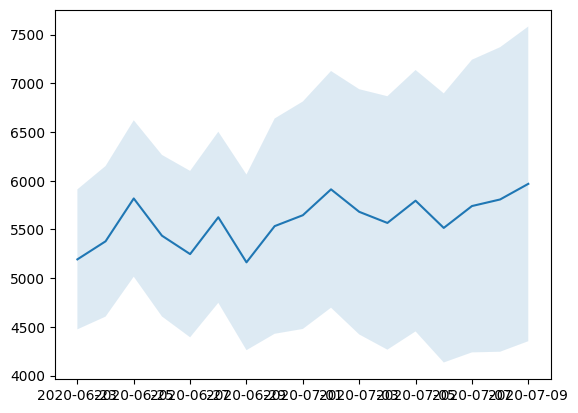

In [65]:
plt.plot(yhat, zorder=1)
plt.fill_between(yhat.index,
                 yhat_conf_int['lower New_Confirmed'],
                 yhat_conf_int['upper New_Confirmed'],
                 zorder=0,
                 alpha=0.15)

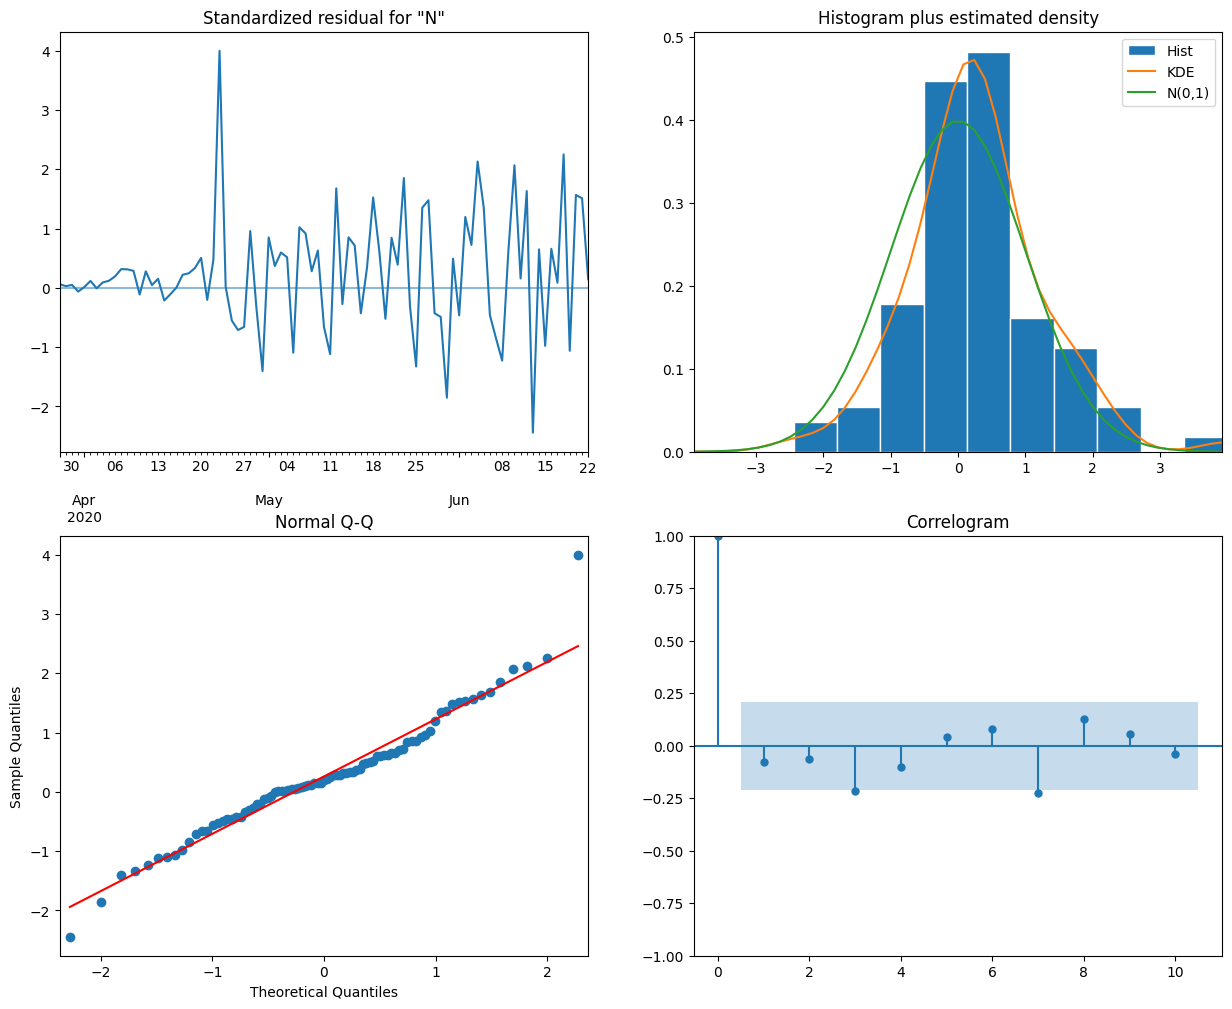

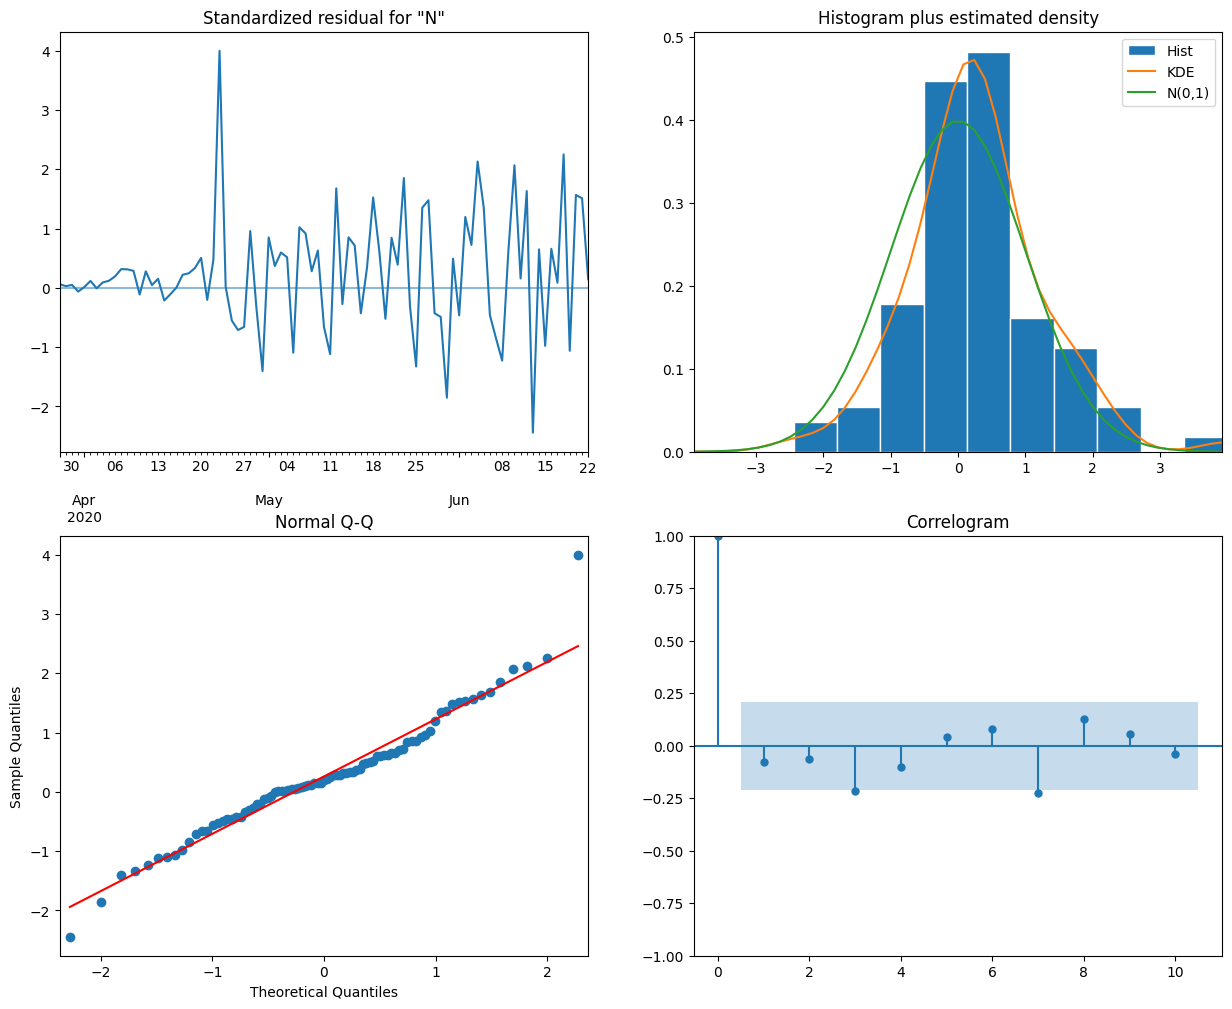

In [66]:
model.plot_diagnostics(figsize=(15,12))


In [67]:
fcast = model.get_forecast(127).summary_frame()
print(fcast)

New_Confirmed         mean      mean_se  mean_ci_lower  mean_ci_upper
2020-06-23     5192.523776   366.693401    4473.817917    5911.229635
2020-06-24     5377.981918   394.493286    4604.789284    6151.174551
2020-06-25     5817.759149   409.775799    5014.613342    6620.904956
2020-06-26     5435.760212   423.127301    4606.445941    6265.074482
2020-06-27     5246.693588   435.866266    4392.411405    6100.975771
...                    ...          ...            ...            ...
2020-10-23     6054.029850  2777.829239     609.584586   11498.475115
2020-10-24     6053.994151  2790.312729     585.081696   11522.906606
2020-10-25     6054.065527  2802.740616     560.794863   11547.336192
2020-10-26     6053.978186  2815.113637     536.456846   11571.499526
2020-10-27     6054.048369  2827.436412     512.374833   11595.721905

[127 rows x 4 columns]


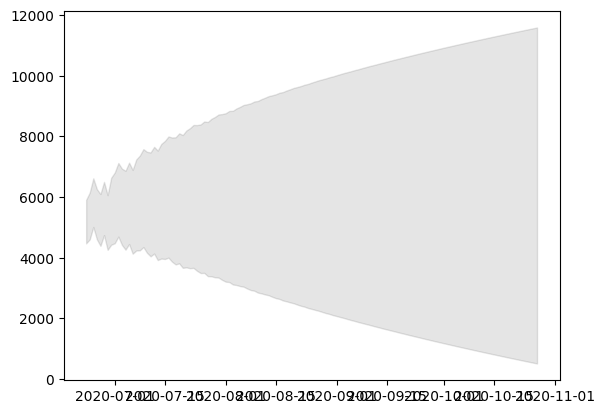

In [68]:
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);    


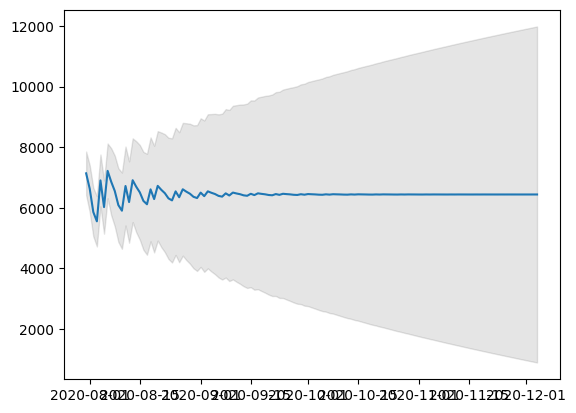

In [73]:
model2 = model.apply(test_data)
fcst = model2.get_forecast(127).summary_frame()
plt.plot(fcst['mean'])
plt.fill_between(fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], color='k', alpha=0.1);    
